In [1]:
import sys
sys.path.insert(1, '../..')

import torch
import torch.nn as nn
import random
import pandas as pd
import numpy as np
import time
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

torch.manual_seed(33)
np.random.seed(33)
random.seed(33)

from library.evaluation import ConfusionMatrix

dataset_name = "Twitter15-RNR"
unique_name = "BERT_Finetuned"

c:\Users\msi_b\anaconda3\envs\pytorch-env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
vectors = np.loadtxt("../../data/vectors/Twitter15-RNR_BERT_base_finetuned_vectors.txt", delimiter=",")
vectors.shape

(1490, 768)

In [3]:
data = pd.read_csv("../../data/processed/twitter15_dataset_with_tvt.csv", lineterminator="\n")
data

,tweet_id,tweet_text,label,tvt,cv_fold,tt,tvt2,tvt2_1,tvt2_2,tvt2_3
0,731166399389962242,🔥ca kkk grand wizard 🔥 endorses @hillaryclinto...,unverified,training,1,training,training,validation,training,training
1,714598641827246081,an open letter to trump voters from his top st...,unverified,training,1,test,training,testting,training,training
2,691809004356501505,america is a nation of second chances —@potus ...,non-rumor,training,2,training,validation,validation,validation,testting
3,693204708933160960,"brandon marshall visits and offers advice, sup...",non-rumor,training,1,training,testting,testting,training,training
4,551099691702956032,rip elly may clampett: so sad to learn #beverl...,true,training,3,training,validation,training,validation,training
...,...,...,...,...,...,...,...,...,...,...
1485,692004901455556608,.@potus just announced new reforms to address ...,non-rumor,training,1,test,training,testting,training,training
1486,760109079133990912,“after school satan clubs”? URL\r,unverified,training,2,training,training,validation,training,validation
1487,500281131057811456,breaking news: according to documents released...,unverified,training,1,training,training,training,validation,validation
1488,523098334421319680,ebola vaccines? URL #news #today\r,false,training,1,training,training,training,testting,validation


In [4]:
labels_str = ['rumour', 'non-rumour']
labels_str

['rumour', 'non-rumour']

In [5]:
labels = []
for i, d in data.iterrows():
#     lab = labels_str.index(d['label'])
    if d['label'] in ['true', 'false', 'unverified']:
        lab = 0
    else:
        lab = 1
    labels.append(lab)
labels[:10]

[0, 0, 1, 1, 0, 1, 0, 0, 0, 0]

In [6]:
print(f"Rumours: {labels.count(0)}")
print(f"Non-rumours: {labels.count(1)}")

Rumours: 1116
Non-rumours: 374


In [7]:
train_vectors = np.array([vectors[i] for i, d in data.iterrows() if d['tvt2'] == 'training'])
val_vectors = np.array([vectors[i] for i, d in data.iterrows() if d['tvt2'] == 'validation'])
test_vectors = np.array([vectors[i] for i, d in data.iterrows() if d['tvt2'] == 'testting'])

train_labels = np.array([labels[i] for i, d in data.iterrows() if d['tvt2'] == 'training'])
val_labels = np.array([labels[i] for i, d in data.iterrows() if d['tvt2'] == 'validation'])
test_labels = np.array([labels[i] for i, d in data.iterrows() if d['tvt2'] == 'testting'])

In [8]:
print(train_vectors.shape)
print(val_vectors.shape)
print(test_vectors.shape)

print(train_labels.shape)
print(val_labels.shape)
print(test_labels.shape)

(1024, 768)
(338, 768)
(128, 768)
(1024,)
(338,)
(128,)


In [9]:
for_cv_vectors = np.concatenate((train_vectors, val_vectors))
train_vectors = None
val_vectors = None
print(for_cv_vectors.shape)

(1362, 768)


In [10]:
for_cv_labels = np.concatenate((train_labels, val_labels))
train_labels = None
val_labels = None
print(for_cv_labels.shape)

(1362,)


In [11]:
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.optim as optim
import matplotlib.pyplot as plt
import time
import os
from typing import Callable
from tqdm import tqdm


class NNModel(nn.Module):
    def __init__(
        self,
        n_input: int,
        n_output: int = 1
    ):
        super(NNModel, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(n_input, 512),
            nn.LeakyReLU(0.1),
#             nn.BatchNorm1d(512),
            nn.Dropout(p=0.5),
            nn.Linear(512, 512),
            nn.LeakyReLU(0.1),
#             nn.BatchNorm1d(512),
            nn.Dropout(p=0.5),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.1),
#             nn.BatchNorm1d(256),
            nn.Dropout(p=0.5),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.1),
#             nn.BatchNorm1d(128),
            nn.Dropout(p=0.5),
            nn.Linear(128, n_output)
        )

    def forward(self, input):
        return self.main(input)
    

class NNClassifier:
    def __init__(self,
        n_input: int,
        n_output: int = 1,
        criterion: Callable = nn.BCELoss,
        beta1: float = 0.5,
        lr: float = 0.0002,
        device: str = None
    ):
        super(NNClassifier, self).__init__()
        self.model = NNModel(n_input, n_output)

        self.criterion = criterion()
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr, betas=(beta1, 0.999), weight_decay=1e-5)

        if not device or device not in ['cpu', 'cuda']:
            self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        else:
            self.device = device

        self.model = self.model.to(self.device)
        if self.device == 'cuda':
            self.model = torch.nn.DataParallel(self.model)
            cudnn.benchmark = True
    
    def load_pretrained(self, filepath: str, key: str = "net", is_parallel: bool = False):
        checkpoint = torch.load(filepath)
        if is_parallel:
            self.model = torch.nn.DataParallel(self.model)
            cudnn.benchmark = True

        print(f"loading model from {filepath}...")
#         print(checkpoint[key])
        self.model.load_state_dict(checkpoint[key], strict=False)
    
    def save_model(self, saves: str):
        print(f"Saving model...")
        state = {
            'net': self.model.state_dict()
        }
        if not os.path.isdir('models'):
            os.mkdir('models')
        torch.save(state, f"../../data/models/cross-validation/{saves}.pth")
    
    def train_eval(self,
        train_x, train_y,
        test_x, test_y,
        n_iter: int = 100,
        batch_size: int = 128,
        saves: str = None,
        fold: int = None
    ):
        trainset = torch.utils.data.TensorDataset(train_x, train_y) # create your datset
        trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size) # create your dataloader

        testset = torch.utils.data.TensorDataset(test_x, test_y) # create your datset
        testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size) # create your dataloader

        train_accs = []
        train_losses = []
        test_accs = []
        test_losses = []

        print(f"Using {self.device}")
        best_acc = 0
        current_loss = 1000
        best_test_acc = 0
        epoch = 0
        start_time = time.time()
        results = {}
        while True:
            epoch += 1
            self.model.train()
            train_loss = 0
            train_correct = 0
            train_total = 0
            for idx, (inputs, targets) in enumerate(trainloader):
                self.optimizer.zero_grad()
                inputs, targets=inputs.to(self.device), targets.to(self.device)
                outputs = self.model(inputs)
                loss = self.criterion(outputs, targets.long())
                loss.backward()
                self.optimizer.step()

                _, predicted = outputs.max(1)
                train_loss += loss.item()
                train_total += targets.size(0)
                train_correct += predicted.eq(targets).sum().item()
            
            train_acc=100.*train_correct/train_total
            train_accs.append(train_acc)
            train_losses.append(train_loss/len(trainloader))
            

            self.model.eval()
            test_loss = 0
            test_correct = 0
            test_total = 0
            # test_acc = 0
            with torch.no_grad():
                for idx, (inputs, targets) in enumerate(testloader):
                    inputs, targets = inputs.to(self.device), targets.to(self.device)
                    outputs = self.model(inputs)
                    loss = self.criterion(outputs, targets.long())
                    test_loss += loss.item()
            
                    _, predicted = outputs.max(1)
                    test_total += targets.size(0)
                    test_correct += predicted.eq(targets).sum().item()
                
            test_acc=100.*test_correct/test_total
            test_accs.append(test_acc)
            test_losses.append(test_loss/len(testloader))
            
            if (epoch) % round(n_iter/20) == 0:
                print(f"-- Epoch {epoch}, Train_Accuracy : {train_acc}, Validation Accuracy : {test_acc}, Train Loss : {train_loss}, Validation Loss : {test_loss}")

            # Save checkpoint.
            # if saves and test_loss < best_loss:
            #     print(f"Saving after new best loss : {test_loss}")
            #     best_loss = test_loss
            if saves and test_acc > best_test_acc:
                print(f"Saving after new best accuracy : {test_acc}")
                best_test_acc = test_acc

                state = {
                    'net': self.model.state_dict(),
                }
                if not os.path.isdir('models'):
                    os.mkdir('models')
                torch.save(state, f"../../data/models/cross-validation/{saves}.pth")
            
            if epoch >= n_iter:
                break
            
        # visualizing accuracy over epoch
        fig, ax2 = plt.subplots(1)
        plt.subplots_adjust(hspace=1.5, wspace=0.4)
        ax2.plot([i for i in range(len(train_accs))], train_accs, label='Training Accuracy')
        ax2.plot([i for i in range(len(test_accs))], test_accs, label='Validation Accuracy')
        ax2.set_ylabel('Accuracy')
        ax2.set_xlabel('Epoch')
        # ax2.set_xlim(0, len(train_losses))
        # ax2.set_ylim(min([min(train_losses), min(test_losses)])*0.1, max([max(train_losses), max(test_losses)]))
        ax2.title.set_text(f"Training and Validation Accuracy Over Time (epoch) Fold {fold}")
        ax2.legend(loc='lower right')

        plt.show()
        fig.savefig(f"../../Grafik/Accuracy/Cross-Validation/{dataset_name}_4LayerNet_L2Reg_{unique_name}_Accuracy_Graph_Fold{fold}.png")
        
        # visualizing accuracy over epoch
        fig, ax2 = plt.subplots(1)
        plt.subplots_adjust(hspace=1.5, wspace=0.4)
        ax2.plot([i for i in range(len(train_losses))], train_losses, label='Training Loss')
        ax2.plot([i for i in range(len(test_losses))], test_losses, label='Validation Loss')
        ax2.set_ylabel('Loss')
        ax2.set_xlabel('Epoch')
        # ax2.set_xlim(0, len(train_losses))
        # ax2.set_ylim(min([min(train_losses), min(test_losses)])*0.1, max([max(train_losses), max(test_losses)]))
        ax2.title.set_text(f"Training and Validation Loss Over Time (epoch) Fold {fold}")
        ax2.legend(loc='lower right')

        plt.show()
        fig.savefig(f"../../Grafik/Loss/Cross-Validation/{dataset_name}_4LayerNet_L2Reg_{unique_name}_Loss_Graph_Fold{fold}.png")
    
    def predict(self, input_x):
        self.model.eval()
        with torch.no_grad():
            preds = self.model(torch.Tensor(input_x))
            preds = torch.log_softmax(preds, dim = 1)
            _, preds = torch.max(preds, dim = 1)
            return preds

In [12]:
from sklearn.model_selection import StratifiedKFold

kf = StratifiedKFold(n_splits=5)

Multiclass Classification using 4-Layer Linear Network Cross Validation
--- FOLD 1 ----
Using cuda
Saving after new best accuracy : 74.72527472527473
Saving after new best accuracy : 85.71428571428571
Saving after new best accuracy : 93.77289377289377
Saving after new best accuracy : 98.16849816849818
Saving after new best accuracy : 99.26739926739927
Saving after new best accuracy : 99.63369963369964
Saving after new best accuracy : 100.0
-- Epoch 50, Train_Accuracy : 96.05142332415059, Validation Accuracy : 99.63369963369964, Train Loss : 0.3538571894168854, Validation Loss : 0.019691843539476395
-- Epoch 100, Train_Accuracy : 97.97979797979798, Validation Accuracy : 98.9010989010989, Train Loss : 0.1796594113111496, Validation Loss : 0.03852364420890808
-- Epoch 150, Train_Accuracy : 98.89807162534436, Validation Accuracy : 97.43589743589743, Train Loss : 0.0961151598021388, Validation Loss : 0.0749024972319603
-- Epoch 200, Train_Accuracy : 98.62258953168045, Validation Accuracy : 

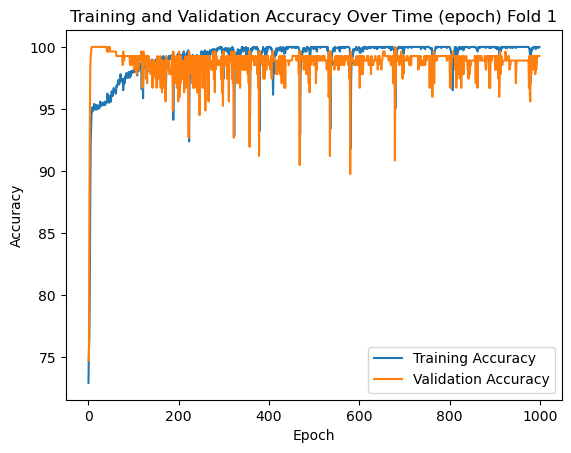

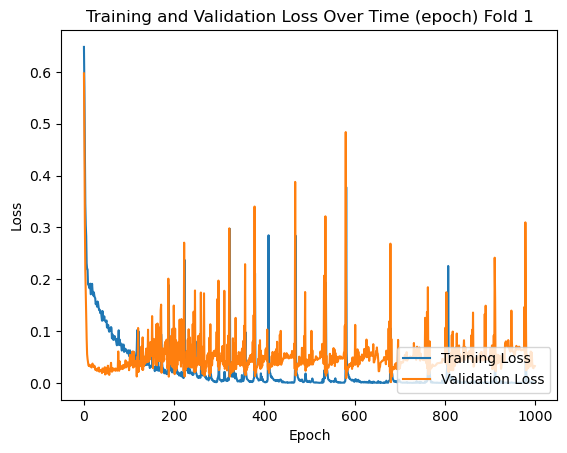

Exec Time : 24.78 seconds
loading model from ../../data/models/cross-validation/Twitter15-RNR_4LayerNet_L2Reg_BERT_Finetuned_Fold1.pth...

Train Set
Predictions : torch.Size([1089])
Binary Class Evaluation

True Positive : 230
False Positive : 10
False Negative : 44
True Negative : 805

Class non-rumour Evaluation
- Precision : 95.833 %
- Recall : 83.942 %
- F1 : 0.89494

Class rumour Evaluation
- Precision : 94.817 %
- Recall : 98.773 %
- F1 : 0.96755

Combined Evaluation
- Accuracy : 95.041 %
- Precision : 95.325 %
- Recall : 91.357 %
- F1 : 0.93299
- Average Confidence : 100.0 %
Model, Combined,,,,non-rumour,,,rumour,,,
Twitter15-RNR_4LayerNet_L2Reg_BERT_Finetuned_Fold1 Train, 95.041, 95.325, 91.357, 0.93299, 95.833, 83.942, 0.89494, 94.817, 98.773, 0.96755, 
Confusion Matrix Scikit-learn: 
[[805  10]
 [ 44 230]]


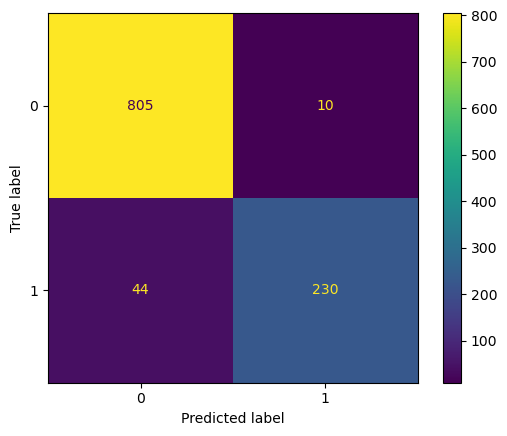


Validation Set
Predictions : torch.Size([273])
Binary Class Evaluation

True Positive : 69
False Positive : 0
False Negative : 0
True Negative : 204

Class non-rumour Evaluation
- Precision : 100.0 %
- Recall : 100.0 %
- F1 : 1.0

Class rumour Evaluation
- Precision : 100.0 %
- Recall : 100.0 %
- F1 : 1.0

Combined Evaluation
- Accuracy : 100.0 %
- Precision : 100.0 %
- Recall : 100.0 %
- F1 : 1.0
- Average Confidence : 100.0 %
Model, Combined,,,,non-rumour,,,rumour,,,
Twitter15-RNR_4LayerNet_L2Reg_BERT_Finetuned_Fold1 Validation, 100.0, 100.0, 100.0, 1.0, 100.0, 100.0, 1.0, 100.0, 100.0, 1.0, 
Confusion Matrix Scikit-learn: 
[[204   0]
 [  0  69]]


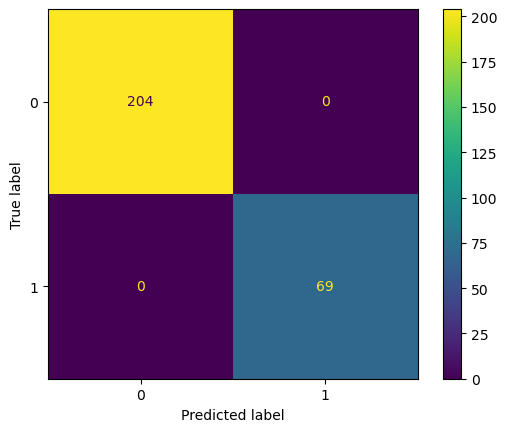


Test Set
Predictions : torch.Size([128])
Binary Class Evaluation

True Positive : 18
False Positive : 2
False Negative : 13
True Negative : 95

Class non-rumour Evaluation
- Precision : 90.0 %
- Recall : 58.065 %
- F1 : 0.70588

Class rumour Evaluation
- Precision : 87.963 %
- Recall : 97.938 %
- F1 : 0.92683

Combined Evaluation
- Accuracy : 88.281 %
- Precision : 88.981 %
- Recall : 78.001 %
- F1 : 0.8313
- Average Confidence : 100.0 %
Model, Combined,,,,non-rumour,,,rumour,,,
Twitter15-RNR_4LayerNet_L2Reg_BERT_Finetuned_Fold1 Test, 88.281, 88.981, 78.001, 0.8313, 90.0, 58.065, 0.70588, 87.963, 97.938, 0.92683, 
128
128
Confusion Matrix Scikit-learn: 
[[95  2]
 [13 18]]


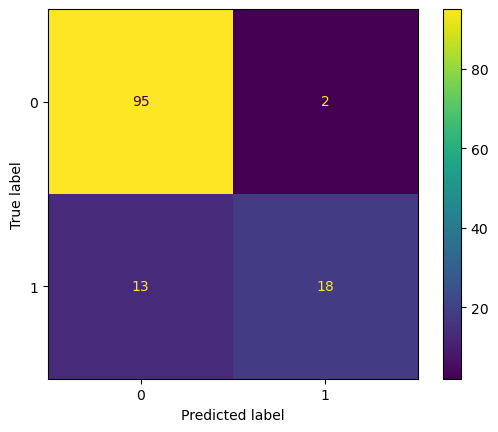

--- FOLD 2 ----
Using cuda
Saving after new best accuracy : 74.72527472527473
Saving after new best accuracy : 85.34798534798534
Saving after new best accuracy : 94.87179487179488
Saving after new best accuracy : 97.43589743589743
Saving after new best accuracy : 99.26739926739927
Saving after new best accuracy : 100.0
-- Epoch 50, Train_Accuracy : 96.23507805325987, Validation Accuracy : 100.0, Train Loss : 0.36185417138040066, Validation Loss : 0.021491484716534615
-- Epoch 100, Train_Accuracy : 97.52066115702479, Validation Accuracy : 99.63369963369964, Train Loss : 0.21056839637458324, Validation Loss : 0.01498482283204794
-- Epoch 150, Train_Accuracy : 98.98989898989899, Validation Accuracy : 99.26739926739927, Train Loss : 0.09776091668754816, Validation Loss : 0.011145206168293953
-- Epoch 200, Train_Accuracy : 99.08172635445362, Validation Accuracy : 99.63369963369964, Train Loss : 0.06049139052629471, Validation Loss : 0.008545788936316967
-- Epoch 250, Train_Accuracy : 99.173

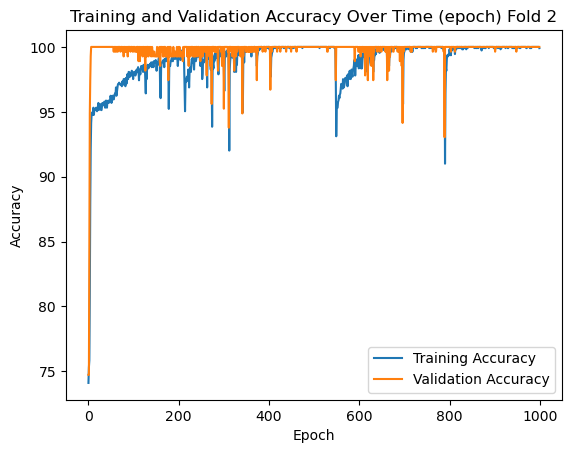

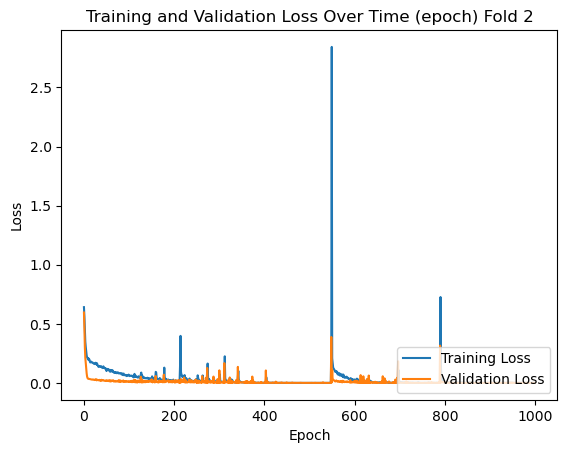

Exec Time : 24.01 seconds
loading model from ../../data/models/cross-validation/Twitter15-RNR_4LayerNet_L2Reg_BERT_Finetuned_Fold2.pth...

Train Set
Predictions : torch.Size([1089])
Binary Class Evaluation

True Positive : 225
False Positive : 8
False Negative : 49
True Negative : 807

Class non-rumour Evaluation
- Precision : 96.567 %
- Recall : 82.117 %
- F1 : 0.88757

Class rumour Evaluation
- Precision : 94.276 %
- Recall : 99.018 %
- F1 : 0.96589

Combined Evaluation
- Accuracy : 94.766 %
- Precision : 95.421 %
- Recall : 90.568 %
- F1 : 0.92931
- Average Confidence : 100.0 %
Model, Combined,,,,non-rumour,,,rumour,,,
Twitter15-RNR_4LayerNet_L2Reg_BERT_Finetuned_Fold2 Train, 94.766, 95.421, 90.568, 0.92931, 96.567, 82.117, 0.88757, 94.276, 99.018, 0.96589, 
Confusion Matrix Scikit-learn: 
[[807   8]
 [ 49 225]]


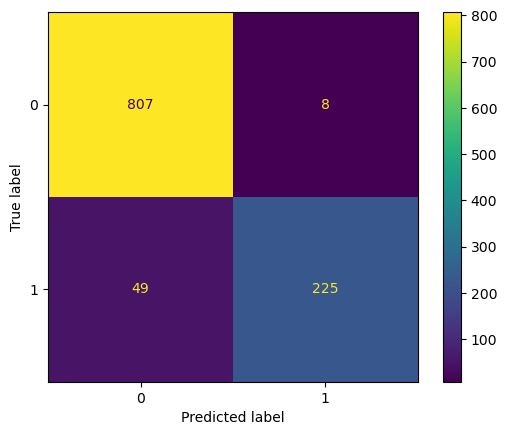


Validation Set
Predictions : torch.Size([273])
Binary Class Evaluation

True Positive : 69
False Positive : 0
False Negative : 0
True Negative : 204

Class non-rumour Evaluation
- Precision : 100.0 %
- Recall : 100.0 %
- F1 : 1.0

Class rumour Evaluation
- Precision : 100.0 %
- Recall : 100.0 %
- F1 : 1.0

Combined Evaluation
- Accuracy : 100.0 %
- Precision : 100.0 %
- Recall : 100.0 %
- F1 : 1.0
- Average Confidence : 100.0 %
Model, Combined,,,,non-rumour,,,rumour,,,
Twitter15-RNR_4LayerNet_L2Reg_BERT_Finetuned_Fold2 Validation, 100.0, 100.0, 100.0, 1.0, 100.0, 100.0, 1.0, 100.0, 100.0, 1.0, 
Confusion Matrix Scikit-learn: 
[[204   0]
 [  0  69]]


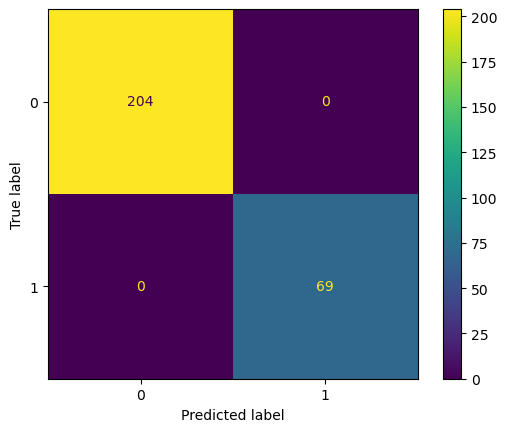


Test Set
Predictions : torch.Size([128])
Binary Class Evaluation

True Positive : 18
False Positive : 2
False Negative : 13
True Negative : 95

Class non-rumour Evaluation
- Precision : 90.0 %
- Recall : 58.065 %
- F1 : 0.70588

Class rumour Evaluation
- Precision : 87.963 %
- Recall : 97.938 %
- F1 : 0.92683

Combined Evaluation
- Accuracy : 88.281 %
- Precision : 88.981 %
- Recall : 78.001 %
- F1 : 0.8313
- Average Confidence : 100.0 %
Model, Combined,,,,non-rumour,,,rumour,,,
Twitter15-RNR_4LayerNet_L2Reg_BERT_Finetuned_Fold2 Test, 88.281, 88.981, 78.001, 0.8313, 90.0, 58.065, 0.70588, 87.963, 97.938, 0.92683, 
128
128
Confusion Matrix Scikit-learn: 
[[95  2]
 [13 18]]


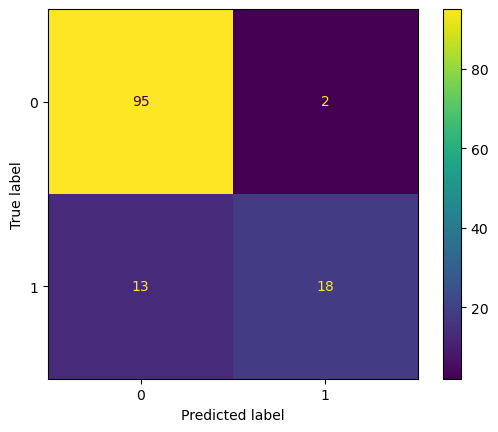

--- FOLD 3 ----
Using cuda
Saving after new best accuracy : 81.98529411764706
Saving after new best accuracy : 90.07352941176471
Saving after new best accuracy : 95.22058823529412
Saving after new best accuracy : 97.79411764705883
Saving after new best accuracy : 98.52941176470588
Saving after new best accuracy : 99.63235294117646
Saving after new best accuracy : 100.0
-- Epoch 50, Train_Accuracy : 95.77981651376147, Validation Accuracy : 100.0, Train Loss : 0.3397773038595915, Validation Loss : 0.02484668791294098
-- Epoch 100, Train_Accuracy : 98.34862385321101, Validation Accuracy : 98.52941176470588, Train Loss : 0.16977050807327032, Validation Loss : 0.036903079599142075
-- Epoch 150, Train_Accuracy : 98.89908256880734, Validation Accuracy : 99.63235294117646, Train Loss : 0.1020600451156497, Validation Loss : 0.01999630033969879
-- Epoch 200, Train_Accuracy : 97.33944954128441, Validation Accuracy : 100.0, Train Loss : 0.19201179593801498, Validation Loss : 0.03013078309595585
--

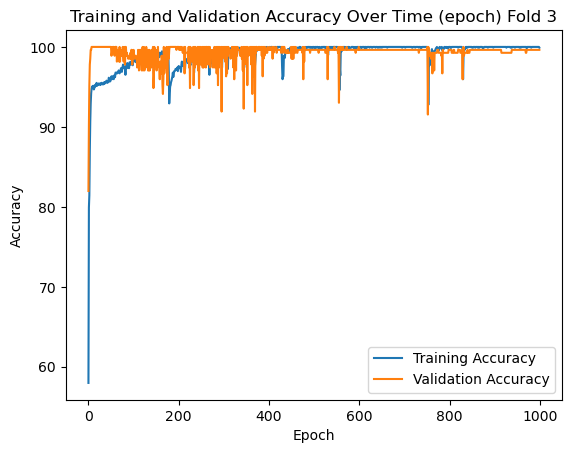

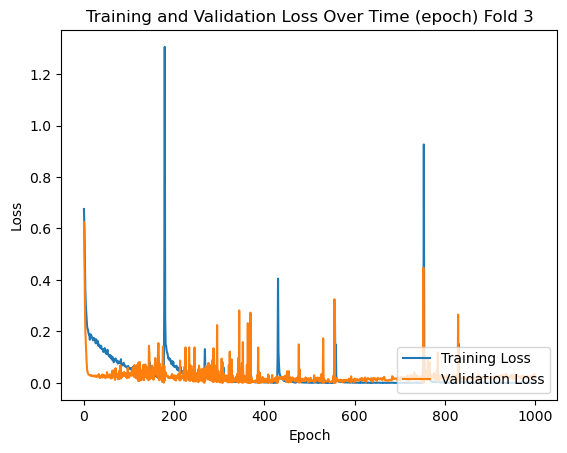

Exec Time : 23.92 seconds
loading model from ../../data/models/cross-validation/Twitter15-RNR_4LayerNet_L2Reg_BERT_Finetuned_Fold3.pth...

Train Set
Predictions : torch.Size([1090])
Binary Class Evaluation

True Positive : 232
False Positive : 10
False Negative : 43
True Negative : 805

Class non-rumour Evaluation
- Precision : 95.868 %
- Recall : 84.364 %
- F1 : 0.89749

Class rumour Evaluation
- Precision : 94.929 %
- Recall : 98.773 %
- F1 : 0.96813

Combined Evaluation
- Accuracy : 95.138 %
- Precision : 95.399 %
- Recall : 91.568 %
- F1 : 0.93444
- Average Confidence : 100.0 %
Model, Combined,,,,non-rumour,,,rumour,,,
Twitter15-RNR_4LayerNet_L2Reg_BERT_Finetuned_Fold3 Train, 95.138, 95.399, 91.568, 0.93444, 95.868, 84.364, 0.89749, 94.929, 98.773, 0.96813, 
Confusion Matrix Scikit-learn: 
[[805  10]
 [ 43 232]]


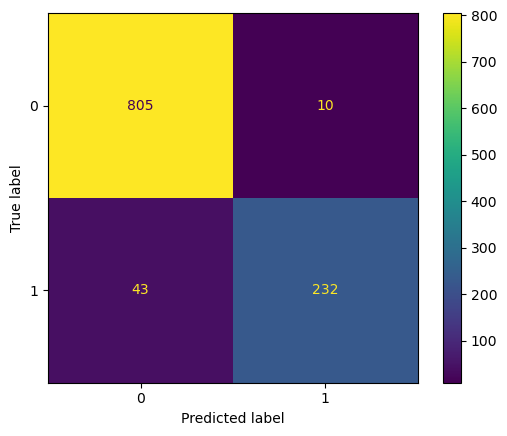


Validation Set
Predictions : torch.Size([272])
Binary Class Evaluation

True Positive : 68
False Positive : 0
False Negative : 0
True Negative : 204

Class non-rumour Evaluation
- Precision : 100.0 %
- Recall : 100.0 %
- F1 : 1.0

Class rumour Evaluation
- Precision : 100.0 %
- Recall : 100.0 %
- F1 : 1.0

Combined Evaluation
- Accuracy : 100.0 %
- Precision : 100.0 %
- Recall : 100.0 %
- F1 : 1.0
- Average Confidence : 100.0 %
Model, Combined,,,,non-rumour,,,rumour,,,
Twitter15-RNR_4LayerNet_L2Reg_BERT_Finetuned_Fold3 Validation, 100.0, 100.0, 100.0, 1.0, 100.0, 100.0, 1.0, 100.0, 100.0, 1.0, 
Confusion Matrix Scikit-learn: 
[[204   0]
 [  0  68]]


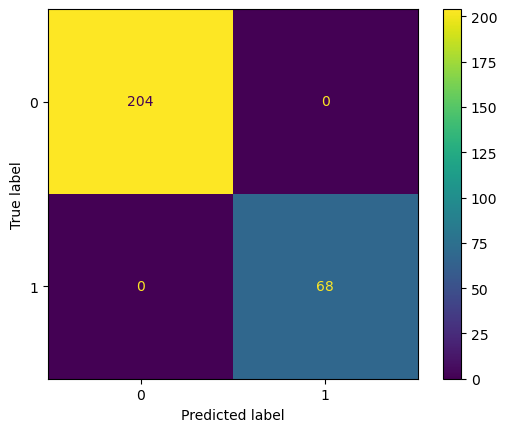


Test Set
Predictions : torch.Size([128])
Binary Class Evaluation

True Positive : 18
False Positive : 2
False Negative : 13
True Negative : 95

Class non-rumour Evaluation
- Precision : 90.0 %
- Recall : 58.065 %
- F1 : 0.70588

Class rumour Evaluation
- Precision : 87.963 %
- Recall : 97.938 %
- F1 : 0.92683

Combined Evaluation
- Accuracy : 88.281 %
- Precision : 88.981 %
- Recall : 78.001 %
- F1 : 0.8313
- Average Confidence : 100.0 %
Model, Combined,,,,non-rumour,,,rumour,,,
Twitter15-RNR_4LayerNet_L2Reg_BERT_Finetuned_Fold3 Test, 88.281, 88.981, 78.001, 0.8313, 90.0, 58.065, 0.70588, 87.963, 97.938, 0.92683, 
128
128
Confusion Matrix Scikit-learn: 
[[95  2]
 [13 18]]


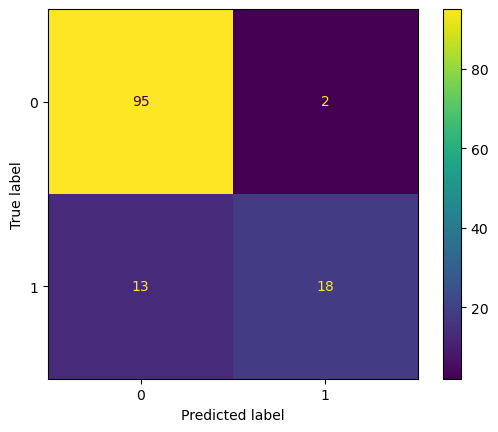

--- FOLD 4 ----
Using cuda
Saving after new best accuracy : 75.0
Saving after new best accuracy : 80.88235294117646
Saving after new best accuracy : 87.86764705882354
Saving after new best accuracy : 92.27941176470588
Saving after new best accuracy : 94.11764705882354
Saving after new best accuracy : 95.58823529411765
Saving after new best accuracy : 95.95588235294117
Saving after new best accuracy : 96.32352941176471
Saving after new best accuracy : 96.69117647058823
-- Epoch 50, Train_Accuracy : 96.97247706422019, Validation Accuracy : 96.32352941176471, Train Loss : 0.26158743910491467, Validation Loss : 0.15402212738990784
-- Epoch 100, Train_Accuracy : 98.44036697247707, Validation Accuracy : 95.95588235294117, Train Loss : 0.15361655270680785, Validation Loss : 0.19078002870082855
-- Epoch 150, Train_Accuracy : 99.1743119266055, Validation Accuracy : 96.32352941176471, Train Loss : 0.07770405896008015, Validation Loss : 0.2212962955236435
-- Epoch 200, Train_Accuracy : 99.6330275

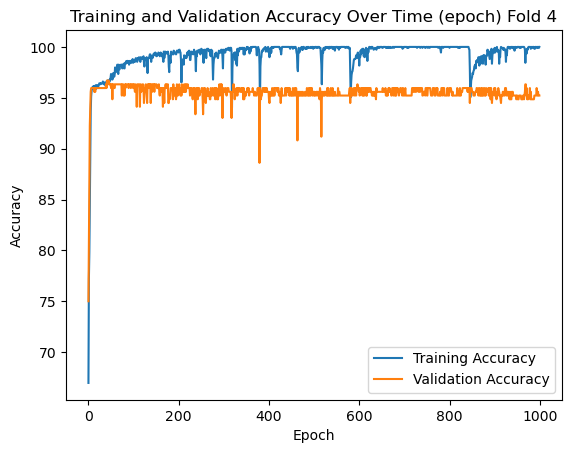

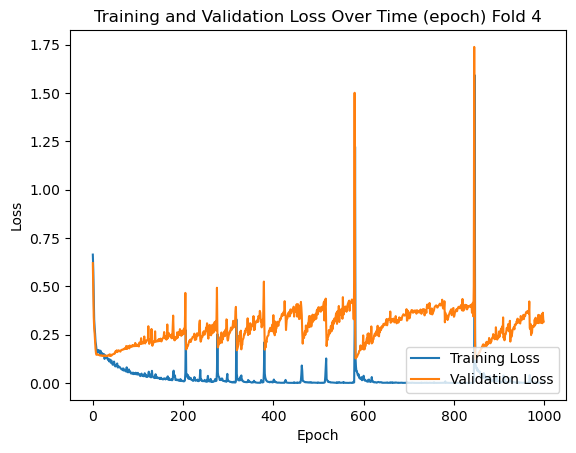

Exec Time : 22.92 seconds
loading model from ../../data/models/cross-validation/Twitter15-RNR_4LayerNet_L2Reg_BERT_Finetuned_Fold4.pth...

Train Set
Predictions : torch.Size([1090])
Binary Class Evaluation

True Positive : 254
False Positive : 12
False Negative : 21
True Negative : 803

Class non-rumour Evaluation
- Precision : 95.489 %
- Recall : 92.364 %
- F1 : 0.939

Class rumour Evaluation
- Precision : 97.451 %
- Recall : 98.528 %
- F1 : 0.97987

Combined Evaluation
- Accuracy : 96.972 %
- Precision : 96.47 %
- Recall : 95.446 %
- F1 : 0.95955
- Average Confidence : 100.0 %
Model, Combined,,,,non-rumour,,,rumour,,,
Twitter15-RNR_4LayerNet_L2Reg_BERT_Finetuned_Fold4 Train, 96.972, 96.47, 95.446, 0.95955, 95.489, 92.364, 0.939, 97.451, 98.528, 0.97987, 
Confusion Matrix Scikit-learn: 
[[803  12]
 [ 21 254]]


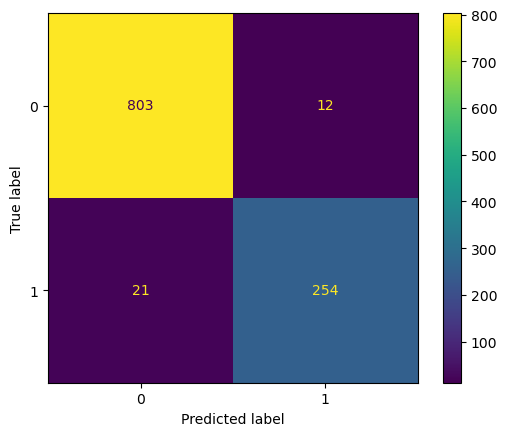


Validation Set
Predictions : torch.Size([272])
Binary Class Evaluation

True Positive : 61
False Positive : 2
False Negative : 7
True Negative : 202

Class non-rumour Evaluation
- Precision : 96.825 %
- Recall : 89.706 %
- F1 : 0.9313

Class rumour Evaluation
- Precision : 96.651 %
- Recall : 99.02 %
- F1 : 0.97821

Combined Evaluation
- Accuracy : 96.691 %
- Precision : 96.738 %
- Recall : 94.363 %
- F1 : 0.95536
- Average Confidence : 100.0 %
Model, Combined,,,,non-rumour,,,rumour,,,
Twitter15-RNR_4LayerNet_L2Reg_BERT_Finetuned_Fold4 Validation, 96.691, 96.738, 94.363, 0.95536, 96.825, 89.706, 0.9313, 96.651, 99.02, 0.97821, 
Confusion Matrix Scikit-learn: 
[[202   2]
 [  7  61]]


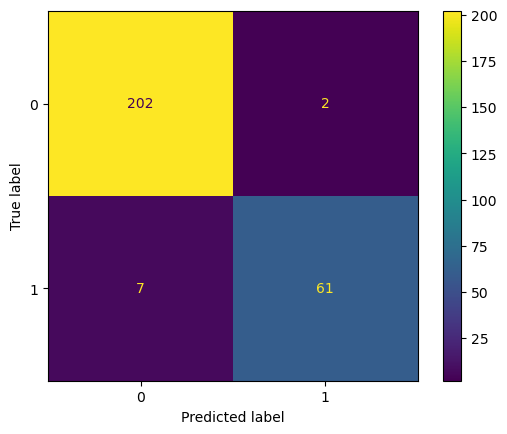


Test Set
Predictions : torch.Size([128])
Binary Class Evaluation

True Positive : 20
False Positive : 8
False Negative : 11
True Negative : 89

Class non-rumour Evaluation
- Precision : 71.429 %
- Recall : 64.516 %
- F1 : 0.67797

Class rumour Evaluation
- Precision : 89.0 %
- Recall : 91.753 %
- F1 : 0.90355

Combined Evaluation
- Accuracy : 85.156 %
- Precision : 80.214 %
- Recall : 78.134 %
- F1 : 0.7916
- Average Confidence : 100.0 %
Model, Combined,,,,non-rumour,,,rumour,,,
Twitter15-RNR_4LayerNet_L2Reg_BERT_Finetuned_Fold4 Test, 85.156, 80.214, 78.134, 0.7916, 71.429, 64.516, 0.67797, 89.0, 91.753, 0.90355, 
128
128
Confusion Matrix Scikit-learn: 
[[89  8]
 [11 20]]


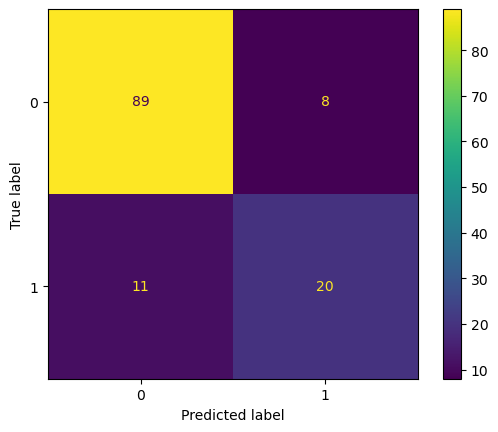

--- FOLD 5 ----
Using cuda
Saving after new best accuracy : 74.63235294117646
Saving after new best accuracy : 76.1029411764706
Saving after new best accuracy : 77.94117647058823
Saving after new best accuracy : 80.51470588235294
Saving after new best accuracy : 81.25
Saving after new best accuracy : 82.72058823529412
Saving after new best accuracy : 83.08823529411765
Saving after new best accuracy : 84.19117647058823
-- Epoch 50, Train_Accuracy : 98.9908256880734, Validation Accuracy : 81.98529411764706, Train Loss : 0.35287636891007423, Validation Loss : 0.8379579782485962
-- Epoch 100, Train_Accuracy : 99.72477064220183, Validation Accuracy : 83.08823529411765, Train Loss : 0.03218618035316467, Validation Loss : 1.3281397819519043
-- Epoch 150, Train_Accuracy : 100.0, Validation Accuracy : 83.45588235294117, Train Loss : 0.002650971175171435, Validation Loss : 1.8095391988754272
-- Epoch 200, Train_Accuracy : 100.0, Validation Accuracy : 83.45588235294117, Train Loss : 0.00113451798

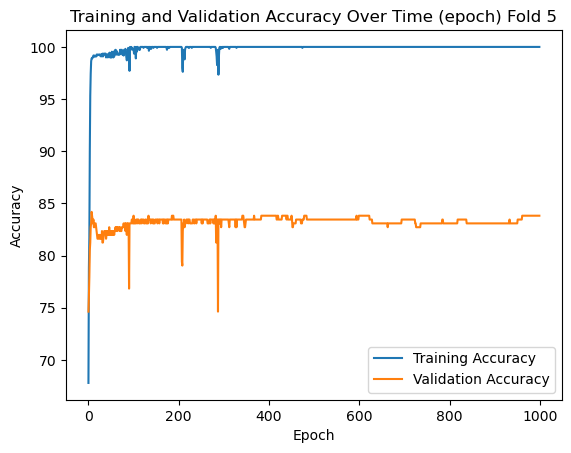

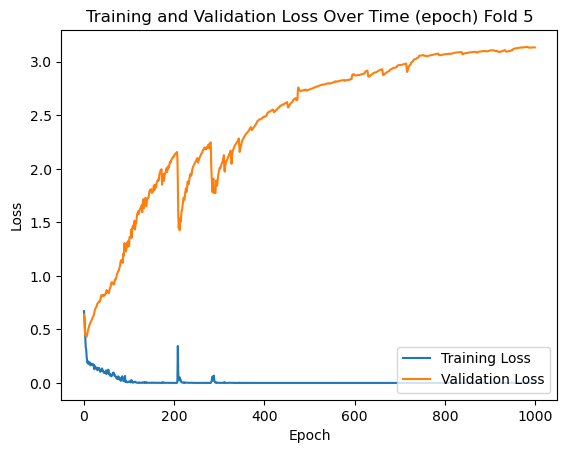

Exec Time : 22.92 seconds
loading model from ../../data/models/cross-validation/Twitter15-RNR_4LayerNet_L2Reg_BERT_Finetuned_Fold5.pth...

Train Set
Predictions : torch.Size([1090])
Binary Class Evaluation

True Positive : 263
False Positive : 0
False Negative : 11
True Negative : 816

Class non-rumour Evaluation
- Precision : 100.0 %
- Recall : 95.985 %
- F1 : 0.97952

Class rumour Evaluation
- Precision : 98.67 %
- Recall : 100.0 %
- F1 : 0.9933

Combined Evaluation
- Accuracy : 98.991 %
- Precision : 99.335 %
- Recall : 97.993 %
- F1 : 0.98659
- Average Confidence : 100.0 %
Model, Combined,,,,non-rumour,,,rumour,,,
Twitter15-RNR_4LayerNet_L2Reg_BERT_Finetuned_Fold5 Train, 98.991, 99.335, 97.993, 0.98659, 100.0, 95.985, 0.97952, 98.67, 100.0, 0.9933, 
Confusion Matrix Scikit-learn: 
[[816   0]
 [ 11 263]]


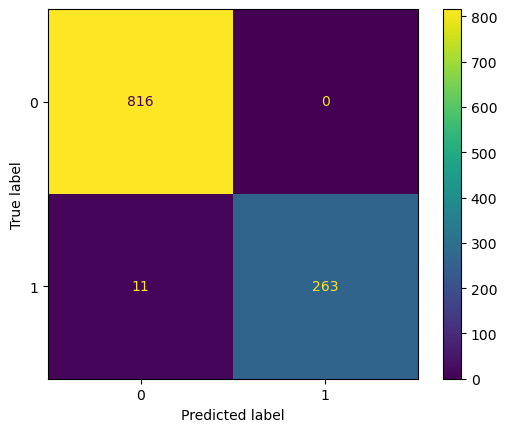


Validation Set
Predictions : torch.Size([272])
Binary Class Evaluation

True Positive : 36
False Positive : 10
False Negative : 33
True Negative : 193

Class non-rumour Evaluation
- Precision : 78.261 %
- Recall : 52.174 %
- F1 : 0.62609

Class rumour Evaluation
- Precision : 85.398 %
- Recall : 95.074 %
- F1 : 0.89977

Combined Evaluation
- Accuracy : 84.191 %
- Precision : 81.83 %
- Recall : 73.624 %
- F1 : 0.7751
- Average Confidence : 100.0 %
Model, Combined,,,,non-rumour,,,rumour,,,
Twitter15-RNR_4LayerNet_L2Reg_BERT_Finetuned_Fold5 Validation, 84.191, 81.83, 73.624, 0.7751, 78.261, 52.174, 0.62609, 85.398, 95.074, 0.89977, 
Confusion Matrix Scikit-learn: 
[[193  10]
 [ 33  36]]


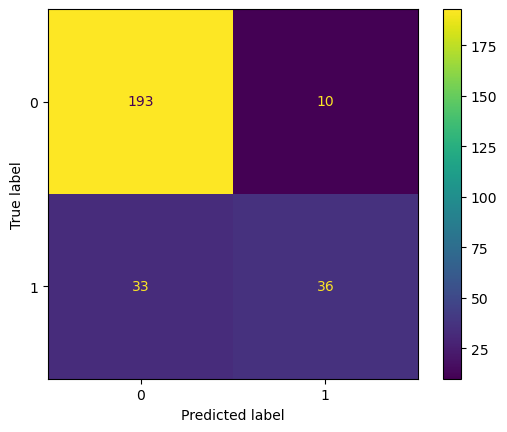


Test Set
Predictions : torch.Size([128])
Binary Class Evaluation

True Positive : 18
False Positive : 2
False Negative : 13
True Negative : 95

Class non-rumour Evaluation
- Precision : 90.0 %
- Recall : 58.065 %
- F1 : 0.70588

Class rumour Evaluation
- Precision : 87.963 %
- Recall : 97.938 %
- F1 : 0.92683

Combined Evaluation
- Accuracy : 88.281 %
- Precision : 88.981 %
- Recall : 78.001 %
- F1 : 0.8313
- Average Confidence : 100.0 %
Model, Combined,,,,non-rumour,,,rumour,,,
Twitter15-RNR_4LayerNet_L2Reg_BERT_Finetuned_Fold5 Test, 88.281, 88.981, 78.001, 0.8313, 90.0, 58.065, 0.70588, 87.963, 97.938, 0.92683, 
128
128
Confusion Matrix Scikit-learn: 
[[95  2]
 [13 18]]


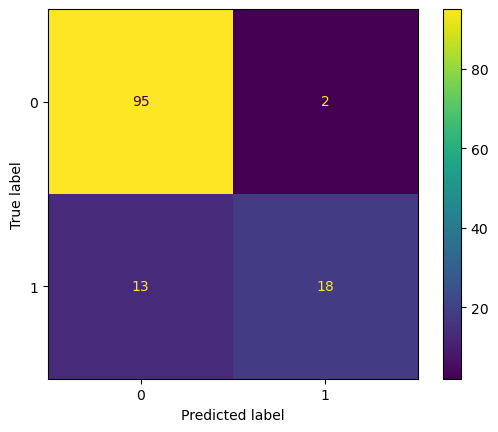

In [13]:
print("Multiclass Classification using 4-Layer Linear Network Cross Validation")

for i, (train_index, test_index) in enumerate(kf.split(for_cv_vectors, for_cv_labels)):
    print(f"--- FOLD {i+1} ----")
    train_vectors = for_cv_vectors[train_index]
    train_labels = for_cv_labels[train_index]
    val_vectors = for_cv_vectors[test_index]
    val_labels = for_cv_labels[test_index]
       
    start = time.time()
    model_name = f"{dataset_name}_4LayerNet_L2Reg_{unique_name}_Fold{i+1}"
    model = NNClassifier(train_vectors.shape[1], n_output=2, criterion=nn.CrossEntropyLoss)
    model.train_eval(torch.Tensor(train_vectors),
                    torch.Tensor(train_labels),
                    torch.Tensor(val_vectors),
                    torch.Tensor(val_labels),
                    saves=model_name,
                    n_iter=1000,
                    batch_size=512,
                    fold=i+1)
    print(f"Exec Time : {round(time.time() - start, 2)} seconds")

    model.load_pretrained(f"../../data/models/cross-validation/{model_name}.pth")

    print("\nTrain Set")
    preds = model.predict(train_vectors)
    print(f"Predictions : {preds.shape}")

    preds = preds.cpu().numpy()

    conf_mat = ConfusionMatrix(
        labels=np.array(train_labels),
        predictions=np.array(preds),
        binary=True,
        model_name=f"{model_name} Train"
    )
    conf_mat.evaluate(classes=labels_str)

    labels=np.array(train_labels)
    predictions=np.array(preds)
    cm = confusion_matrix(labels, predictions, labels=[0,1])
    print(f'Confusion Matrix Scikit-learn: \n{cm}')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
    disp.plot()
    plt.show()

    print("\nValidation Set")
    preds = model.predict(val_vectors)
    print(f"Predictions : {preds.shape}")

    preds = preds.cpu().numpy()

    conf_mat = ConfusionMatrix(
        labels=np.array(val_labels),
        predictions=np.array(preds),
        binary=True,
        model_name=f"{model_name} Validation"
    )
    conf_mat.evaluate(classes=labels_str)

    labels=np.array(val_labels)
    predictions=np.array(preds)
    cm = confusion_matrix(labels, predictions, labels=[0,1])
    print(f'Confusion Matrix Scikit-learn: \n{cm}')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
    disp.plot()
    plt.show()

    print("\nTest Set")
    preds = model.predict(test_vectors)
    print(f"Predictions : {preds.shape}")

    preds = preds.cpu().numpy()

    conf_mat = ConfusionMatrix(
        labels=np.array(test_labels),
        predictions=np.array(preds),
        binary=True,
        model_name=f"{model_name} Test"
    )
    conf_mat.evaluate(classes=labels_str)

    labels=np.array(test_labels)
    predictions=np.array(preds)
    print(len(labels))
    print(len(predictions))
    cm = confusion_matrix(labels, predictions, labels=[0,1])
    print(f'Confusion Matrix Scikit-learn: \n{cm}')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
    disp.plot()
    plt.show()